# 目錄
## ．放入融資融券
### ．．．測試預測幾天後的成效最好（看起來是8天）
### ．．．建立 rolling models
## ．畫Y999股價搭配牛熊顏色的圖
## ．加入其他基本因子
## ．加入新聞輿情與熱度
### ．．．正規化全部因子
## ．加入更多因子
## ．使用不同演算法：logistic regression, naive bayes, SVM
### ．．．logistic regression 進行 feature selections
## ．進行RF feature selections （使用SelectFromModel, RFECV）

# Read in label dataframe

In [22]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

In [2]:
label = pd.read_csv('algoDefLabel.csv')
label['bb'] = label['algoDefine'].apply(lambda x: int(x))

In [3]:
margin = pd.read_csv('./index_data/margin_20050103_20220511.csv', encoding='big5')

In [4]:
filtered_margin = margin[['年月日', '融資餘額(張)', '融資餘額(千元)', '融券餘額(張)', '融券餘額(千元)', '借券賣出餘額(張)', '借券賣出餘額(千元)', '借券賣出可使用額度', '借券賣出限額', '券資比']]

In [5]:
# for i in margin.columns:
#     print(i, end='  ')

公司代碼  簡稱  年月日  

#### 融資餘額(張)  融資餘額(千元)  
    融資買進(張)  融資買進(千元)  
    融資賣出(張)  融資賣出(千元)  
    融資現金償還(張)  融資現金償還(千元)  
    融資增減(張)  融資增減(千元)  融資增減比率  
    融資使用率  融資限額  

#### 融券餘額(張)  融券餘額(千元)  
    融券買進(張)  融券買進(千元)  
    融券賣出(張)  融券賣出(千元)  
    融券現券償還(張)  融券現券償還(千元)  
    融券增減(張)  融券增減(千元)  融券增減比率  
    融券使用率  融券限額  

是否可信用交易(Y)  #### 券資比  資券互抵  當日收盤  

融資(買+賣)/成交量 %  融券(買+賣)/成交量 %  

#### 借券賣出餘額(張)  借券賣出餘額(千元)  
    借券賣出(張)  借券賣出(千元)  
    借券賣出庫存異動(張)  借券賣出庫存異動(千元)  
    #### 借券賣出可使用額度  借券賣出限額  
    借券賣出(千元)_交易所  融券賣出(千元)_交易所  

均價  
每股融資成本  每股融券成本  
融資維持率  融券維持率  整戶維持率  

#### CPI總指數

In [6]:
df = filtered_margin.merge(label[['Date', 'close_adj', 'bb']], left_on='年月日', right_on='Date')

In [7]:
df

,年月日,融資餘額(張),融資餘額(千元),融券餘額(張),融券餘額(千元),借券賣出餘額(張),借券賣出餘額(千元),借券賣出可使用額度,借券賣出限額,券資比,Date,close_adj,bb
0,2008/01/02,17416413,330226419.0,446743,22386158.26,941766,40182569.36,15829848,52766131,2.57,2008/01/02,9845.42,0
1,2008/01/03,17457081,332032980.0,431996,20588767.58,943067,38679629.96,15820023,52733376,2.47,2008/01/03,9681.17,0
2,2008/01/04,17515892,334346118.0,448848,20666002.95,933568,38116807.14,15815849,52719469,2.56,2008/01/04,9724.82,0
3,2008/01/07,17446380,333416251.0,430747,19149243.61,938141,36351105.52,15816449,52721469,2.47,2008/01/07,9325.32,0
4,2008/01/08,17459758,333013941.0,451952,19760438.32,948282,36230978.44,16106439,53688104,2.59,2008/01/08,9419.41,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3530,2022/05/04,8483629,252497763.0,388583,22595578.84,10974527,531024203.68,1341851,76197874,4.58,2022/05/04,32947.47,0
3531,2022/05/05,8518787,253143450.0,398061,23445108.11,10906950,535959494.53,1337917,76205474,4.67,2022/05/05,33206.59,0
3532,2022/05/06,8506707,253016723.0,390208,22495883.07,10824940,523467852.96,1338743,76234516,4.59,2022/05/06,32633.97,0
3533,2022/05/09,8390725,250125870.0,392470,21799703.83,10948167,519945004.74,1338754,76251750,4.68,2022/05/09,31919.41,0


# Start Training

In [8]:
df[df['年月日'] < '2021/01/01']

,年月日,融資餘額(張),融資餘額(千元),融券餘額(張),融券餘額(千元),借券賣出餘額(張),借券賣出餘額(千元),借券賣出可使用額度,借券賣出限額,券資比,Date,close_adj,bb
0,2008/01/02,17416413,330226419.0,446743,22386158.26,941766,40182569.36,15829848,52766131,2.57,2008/01/02,9845.42,0
1,2008/01/03,17457081,332032980.0,431996,20588767.58,943067,38679629.96,15820023,52733376,2.47,2008/01/03,9681.17,0
2,2008/01/04,17515892,334346118.0,448848,20666002.95,933568,38116807.14,15815849,52719469,2.56,2008/01/04,9724.82,0
3,2008/01/07,17446380,333416251.0,430747,19149243.61,938141,36351105.52,15816449,52721469,2.47,2008/01/07,9325.32,0
4,2008/01/08,17459758,333013941.0,451952,19760438.32,948282,36230978.44,16106439,53688104,2.59,2008/01/08,9419.41,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3205,2020/12/25,8745028,184261341.0,1163281,27977389.83,8162513,329407523.66,1792119,72503262,13.30,2020/12/25,27667.00,1
3206,2020/12/28,8868468,186790038.0,1197623,29302775.94,8221767,333830873.72,1810826,72498309,13.50,2020/12/28,27959.77,1
3207,2020/12/29,8777489,185949806.0,1185802,28971069.69,8234700,334385107.12,1836023,72502998,13.51,2020/12/29,27938.50,1
3208,2020/12/30,8842775,187131498.0,1176219,29232796.17,8249918,335615679.12,1854665,72501128,13.30,2020/12/30,28354.81,1


# Add other basic factors

EA1101: 2

EB0308: 14

EB0311: 17

EB0312: 18

EB18: 26

EB23: 31

EC03: 35

EC08: 38

LA07 LA0702: 41 42

#### MA1601: 43

#### PA0110 PA0118: 52 54

In [9]:
df_2 = copy.copy(df)
df_2['年月'] = df['年月日'].apply(lambda x: x[:7])
print(df_2)

files = os.listdir('/Users/arthur/Desktop/bbmarket/index_data/data/')
files = sorted(files)

for i in range(len(files)):
    if i in [2, 14, 17, 18, 26, 31, 35, 38, 41, 42, 43, 52, 54]:
        factor_df = pd.read_excel('/Users/arthur/Desktop/bbmarket/index_data/data/'+files[i])
        
        name = factor_df.columns[0][:-21]
        factor_df.columns =  [factor_df.iloc[1, 0], name, factor_df.iloc[1, 2]]
        factor_df = factor_df.iloc[2:, :].reset_index(drop=True)
        factor_df.columns.name=''
        
        df_2 = df_2.merge(factor_df[['年月', name]], left_on='年月', right_on='年月')
print(df_2)

             年月日   融資餘額(張)     融資餘額(千元)  融券餘額(張)     融券餘額(千元)      借券賣出餘額(張)  \
0     2008/01/02  17416413  330226419.0   446743  22386158.26         941766   
1     2008/01/03  17457081  332032980.0   431996  20588767.58         943067   
2     2008/01/04  17515892  334346118.0   448848  20666002.95         933568   
3     2008/01/07  17446380  333416251.0   430747  19149243.61         938141   
4     2008/01/08  17459758  333013941.0   451952  19760438.32         948282   
...          ...       ...          ...      ...          ...            ...   
3530  2022/05/04   8483629  252497763.0   388583  22595578.84       10974527   
3531  2022/05/05   8518787  253143450.0   398061  23445108.11       10906950   
3532  2022/05/06   8506707  253016723.0   390208  22495883.07       10824940   
3533  2022/05/09   8390725  250125870.0   392470  21799703.83       10948167   
3534  2022/05/10   8303845  248696514.0   378888  20708153.69       10969392   

           借券賣出餘額(千元)      借券賣出可使用額度   

In [10]:
df_2

,年月日,融資餘額(張),融資餘額(千元),融券餘額(張),融券餘額(千元),借券賣出餘額(張),借券賣出餘額(千元),借券賣出可使用額度,借券賣出限額,券資比,...,EB0312 台灣-未來六個月的景氣狀況指數-月(指數),EB18 台灣-消費者信心指數-月(指數),EB23 台灣-消費者信心指數-未來半年投資股票時機-月(指數),EC03 台灣-平均薪資-製造業(經季節調整)-台幣-月(元)(TWD),EC08 台灣股價指數變動率-月均值(百分比),LA07 台灣-失業率-月(百分比),LA0702 台灣-失業率(經季節調整)-月(百分比),MA1601 台灣-貨幣總計數-M2年增率-期底-月(百分比),PA0110 台灣-CPI總指數(2016=100)-月(指數),PA0118 台灣-CPI-總指數(經季節調整)(2016=100)-月(指數)
0,2012/07/02,11354601,184332247.0,395935,18643061.95,3693871,142760926.58,339002,61809354,3.49,...,28.8,75.08,43.6,42906,-17.21,4.31,4.26,3.43,97.56,97.26
1,2012/07/03,11324432,183747671.0,389262,18319450.81,3699195,143115378.27,341893,61817934,3.44,...,28.8,75.08,43.6,42906,-17.21,4.31,4.26,3.43,97.56,97.26
2,2012/07/04,11329324,183677252.0,390571,18671529.97,3705894,144267872.06,345615,61819624,3.45,...,28.8,75.08,43.6,42906,-17.21,4.31,4.26,3.43,97.56,97.26
3,2012/07/05,11320420,185002482.0,400849,19049557.46,3694344,143275412.99,348739,61820174,3.54,...,28.8,75.08,43.6,42906,-17.21,4.31,4.26,3.43,97.56,97.26
4,2012/07/06,11288395,185211790.0,377755,18360801.82,3687225,142397746.56,350158,61820112,3.35,...,28.8,75.08,43.6,42906,-17.21,4.31,4.26,3.43,97.56,97.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2363,2022/02/21,9047852,269854700.0,472224,29151444.56,9607059,508445990.39,1368664,75265561,5.22,...,65.1,73.19,49.7,43175,12.28,3.65,3.67,7.65,105.99,106.66
2364,2022/02/22,8976335,267507030.0,452167,24839569.14,9657960,496051938.90,1385297,75312961,5.04,...,65.1,73.19,49.7,43175,12.28,3.65,3.67,7.65,105.99,106.66
2365,2022/02/23,9038706,269379957.0,480971,28138277.79,9636748,502216015.63,1380078,75329736,5.32,...,65.1,73.19,49.7,43175,12.28,3.65,3.67,7.65,105.99,106.66
2366,2022/02/24,8858978,264032674.0,454160,26394300.69,9661815,490698782.38,1406223,75361826,5.13,...,65.1,73.19,49.7,43175,12.28,3.65,3.67,7.65,105.99,106.66


In [11]:
df_2.columns [ list(range(1, 10))+list(range(14,27)) ]

Index(['融資餘額(張)', '融資餘額(千元)', '融券餘額(張)', '融券餘額(千元)', '借券賣出餘額(張)', '借券賣出餘額(千元)',
       '借券賣出可使用額度', '借券賣出限額', '券資比', 'EA1101 台灣-景氣對策信號綜合分數-月(分數)',
       'EB0308 台灣-原物料價格指數-月(指數)', 'EB0311 台灣-進口原物料數量指數-月(指數)',
       'EB0312 台灣-未來六個月的景氣狀況指數-月(指數)', 'EB18 台灣-消費者信心指數-月(指數)',
       'EB23 台灣-消費者信心指數-未來半年投資股票時機-月(指數)',
       'EC03 台灣-平均薪資-製造業(經季節調整)-台幣-月(元)(TWD)', 'EC08 台灣股價指數變動率-月均值(百分比)',
       'LA07 台灣-失業率-月(百分比)', 'LA0702 台灣-失業率(經季節調整)-月(百分比)',
       'MA1601 台灣-貨幣總計數-M2年增率-期底-月(百分比)', 'PA0110 台灣-CPI總指數(2016=100)-月(指數)',
       'PA0118 台灣-CPI-總指數(經季節調整)(2016=100)-月(指數)'],
      dtype='object')

# 市場輿情分數與熱度

In [12]:
SEN = pd.read_csv('./index_data/sentimentIndex.csv')
SEN.columns = ['年月日'] + list(SEN.columns[1:])
SEN['年月日'] = ['/'.join(i.split('-')) for i in SEN['年月日']]
SEN['Trend'] = SEN.iloc[:, 1:].apply(np.nanmean, axis=1)

HEAT = pd.read_csv('./index_data/heatIndex.csv')
HEAT.columns = ['年月日'] + list(HEAT.columns[1:])
HEAT['年月日'] = ['/'.join(i.split('-')) for i in HEAT['年月日']]
HEAT['Heat'] = HEAT.iloc[:, 1:].apply(np.nanmean, axis=1)

SEN2 = pd.read_csv('./index_data/trendIndex.csv')
SEN2.columns = ['年月日'] + list(SEN2.columns[1:])
SEN2['年月日'] = ['/'.join(i.split('-')) for i in SEN2['年月日']]
SEN2['Trend2'] = SEN2.iloc[:, 1:].apply(np.nanmean, axis=1)

HEAT2 = pd.read_csv('./index_data/heatIndex2.csv')
HEAT2.columns = ['年月日'] + list(HEAT2.columns[1:])
HEAT2['年月日'] = ['/'.join(i.split('-')) for i in HEAT2['年月日']]
HEAT2['Heat2'] = HEAT2.iloc[:, 1:].apply(np.nanmean, axis=1)

In [13]:
df_3 = df_2.merge(SEN[['年月日', 'Trend']], on='年月日')
df_3 = df_3.merge(HEAT[['年月日', 'Heat']], on='年月日')
df_3 = df_3.merge(SEN2[['年月日', 'Trend2']], on='年月日')
df_3 = df_3.merge(HEAT2[['年月日', 'Heat2']], on='年月日')
# df_3 = df_3.merge(margin[margin.columns[2:]], on='年月日')
df_3

,年月日,融資餘額(張),融資餘額(千元),融券餘額(張),融券餘額(千元),借券賣出餘額(張),借券賣出餘額(千元),借券賣出可使用額度,借券賣出限額,券資比,...,EC08 台灣股價指數變動率-月均值(百分比),LA07 台灣-失業率-月(百分比),LA0702 台灣-失業率(經季節調整)-月(百分比),MA1601 台灣-貨幣總計數-M2年增率-期底-月(百分比),PA0110 台灣-CPI總指數(2016=100)-月(指數),PA0118 台灣-CPI-總指數(經季節調整)(2016=100)-月(指數),Trend,Heat,Trend2,Heat2
0,2013/01/02,11202904,180297414.0,869131,37362993.48,4317824,162806822.23,464277,63214239,7.76,...,8.12,4.16,4.2,2.9,97.45,98.48,3.260929,1.000000,0.500000,1.304194
1,2013/01/03,11207000,180690515.0,886405,38371415.22,4265426,163280661.07,475138,63212096,7.91,...,8.12,4.16,4.2,2.9,97.45,98.48,4.971712,0.919214,0.322917,1.217502
2,2013/01/04,11248020,181996929.0,899789,37927615.24,4284513,162851472.10,485618,63213887,8.00,...,8.12,4.16,4.2,2.9,97.45,98.48,4.858022,0.754579,0.546053,1.189524
3,2013/01/07,11297769,183197039.0,888119,36870039.79,4289948,162084860.46,486600,63212395,7.86,...,8.12,4.16,4.2,2.9,97.45,98.48,5.192612,0.549632,0.226415,1.026759
4,2013/01/08,11318550,184412388.0,876746,35271737.14,4285353,160316606.10,486578,63214543,7.75,...,8.12,4.16,4.2,2.9,97.45,98.48,3.953038,0.575573,0.141104,1.012500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2201,2021/12/24,9427245,281583023.0,527298,34149543.16,9697178,520524033.78,1620810,75032644,5.59,...,24.99,3.64,3.7,7.35,105.41,105.95,7.755893,0.202140,0.217687,0.346139
2202,2021/12/27,9452563,282330905.0,527225,33951938.58,9701874,523012279.67,1594671,75023583,5.58,...,24.99,3.64,3.7,7.35,105.41,105.95,8.319634,0.171378,0.476744,0.309086
2203,2021/12/28,9423456,281689753.0,524513,33733375.57,9685959,524227132.23,1567413,75018921,5.57,...,24.99,3.64,3.7,7.35,105.41,105.95,8.252676,0.205510,0.580645,0.327092
2204,2021/12/29,9418022,281976763.0,532419,34097204.71,9631146,520922268.85,1540210,75224171,5.65,...,24.99,3.64,3.7,7.35,105.41,105.95,7.793915,0.194017,0.486842,0.329154


#### 更多因子：Y999股票、不同因子溢酬
#### 不同演算法

## Y999股票trend

In [14]:
df_3.columns

Index(['年月日', '融資餘額(張)', '融資餘額(千元)', '融券餘額(張)', '融券餘額(千元)', '借券賣出餘額(張)',
       '借券賣出餘額(千元)', '借券賣出可使用額度', '借券賣出限額', '券資比', 'Date', 'close_adj', 'bb',
       '年月', 'EA1101 台灣-景氣對策信號綜合分數-月(分數)', 'EB0308 台灣-原物料價格指數-月(指數)',
       'EB0311 台灣-進口原物料數量指數-月(指數)', 'EB0312 台灣-未來六個月的景氣狀況指數-月(指數)',
       'EB18 台灣-消費者信心指數-月(指數)', 'EB23 台灣-消費者信心指數-未來半年投資股票時機-月(指數)',
       'EC03 台灣-平均薪資-製造業(經季節調整)-台幣-月(元)(TWD)', 'EC08 台灣股價指數變動率-月均值(百分比)',
       'LA07 台灣-失業率-月(百分比)', 'LA0702 台灣-失業率(經季節調整)-月(百分比)',
       'MA1601 台灣-貨幣總計數-M2年增率-期底-月(百分比)', 'PA0110 台灣-CPI總指數(2016=100)-月(指數)',
       'PA0118 台灣-CPI-總指數(經季節調整)(2016=100)-月(指數)', 'Trend', 'Heat', 'Trend2',
       'Heat2'],
      dtype='object')

In [35]:
df_3['price_trend'] = df_3['close_adj'].rolling(30).apply(lambda x: x.iloc[-1]-np.nanmean(x))
# df_3['price_trend'] = df_3['close_adj'].rolling(30).apply(lambda x: (x.iloc[-1]-np.nanmean(x)/x.iloc[-1]*10000))

/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


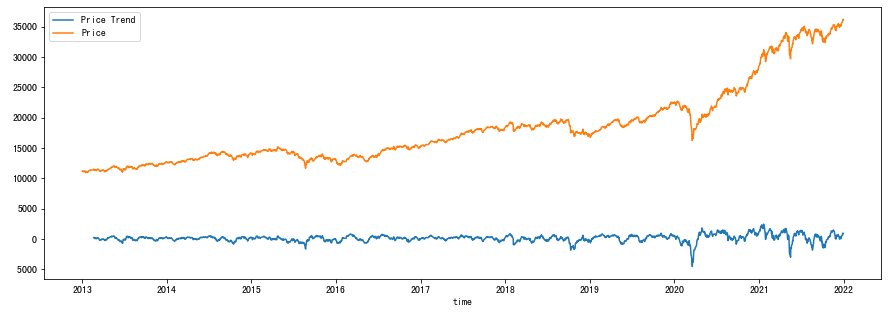

In [36]:
fig = plt.figure(figsize=(15,5))
ax = plt.axes()

# for i in label.index:
ax.plot(pd.to_datetime(df_3.Date), df_3['price_trend'], label='Price Trend')
ax.plot(pd.to_datetime(df_3.Date), df_3['close_adj'], label='Price')

ax.set_xlabel('time')  # Add an x-label to the axes.
# ax.set_ylabel('price')  # Add a y-label to the axes.
ax.legend();  # Add a legend.

In [17]:
df_4 = copy.copy(df_3)
df_4 = df_4.dropna(axis=0)

## 加入其他因子溢酬資料

In [18]:
def extractPremium(name):
    Premium = pd.read_csv('./index_data/'+name+'_Premium.csv')
    Premium.columns = ['年月日', 'HighGroup', 'LowGroup']
    Premium[name+'_Premium'] = Premium.apply(lambda x: x[1]-x[2], axis=1)
    Premium['年月日'] = [i[0:4]+'/'+i[5:7]+'/'+i[8:10] for i in Premium['年月日']]
    return Premium

CTP_Premium = extractPremium('CTP')
EB_Premium = extractPremium('EB')
EP_Premium = extractPremium('EP')
VOL_Premium = extractPremium('VOL')
MOM_Premium = extractPremium('MOM')
SEN_Premium = extractPremium('SEN')
HEAT_Premium = extractPremium('HEAT')
WB_Premium = extractPremium('WB')

In [19]:
df_4 = df_4.merge(CTP_Premium[['年月日', 'CTP_Premium']], on='年月日')
df_4 = df_4.merge(EB_Premium[['年月日', 'EB_Premium']], on='年月日')
df_4 = df_4.merge(EP_Premium[['年月日', 'EP_Premium']], on='年月日')
df_4 = df_4.merge(VOL_Premium[['年月日', 'VOL_Premium']], on='年月日')
df_4 = df_4.merge(MOM_Premium[['年月日', 'MOM_Premium']], on='年月日')
df_4 = df_4.merge(SEN_Premium[['年月日', 'SEN_Premium']], on='年月日')
df_4 = df_4.merge(HEAT_Premium[['年月日', 'HEAT_Premium']], on='年月日')
df_4 = df_4.merge(WB_Premium[['年月日', 'WB_Premium']], on='年月日')

In [20]:
df_4.columns

Index(['年月日', '融資餘額(張)', '融資餘額(千元)', '融券餘額(張)', '融券餘額(千元)', '借券賣出餘額(張)',
       '借券賣出餘額(千元)', '借券賣出可使用額度', '借券賣出限額', '券資比', 'Date', 'close_adj', 'bb',
       '年月', 'EA1101 台灣-景氣對策信號綜合分數-月(分數)', 'EB0308 台灣-原物料價格指數-月(指數)',
       'EB0311 台灣-進口原物料數量指數-月(指數)', 'EB0312 台灣-未來六個月的景氣狀況指數-月(指數)',
       'EB18 台灣-消費者信心指數-月(指數)', 'EB23 台灣-消費者信心指數-未來半年投資股票時機-月(指數)',
       'EC03 台灣-平均薪資-製造業(經季節調整)-台幣-月(元)(TWD)', 'EC08 台灣股價指數變動率-月均值(百分比)',
       'LA07 台灣-失業率-月(百分比)', 'LA0702 台灣-失業率(經季節調整)-月(百分比)',
       'MA1601 台灣-貨幣總計數-M2年增率-期底-月(百分比)', 'PA0110 台灣-CPI總指數(2016=100)-月(指數)',
       'PA0118 台灣-CPI-總指數(經季節調整)(2016=100)-月(指數)', 'Trend', 'Heat', 'Trend2',
       'Heat2', 'price_trend', 'CTP_Premium', 'EB_Premium', 'EP_Premium',
       'VOL_Premium', 'MOM_Premium', 'SEN_Premium', 'HEAT_Premium',
       'WB_Premium'],
      dtype='object')

# 季 - Random Forest - All

In [100]:
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
import time
from sklearn.ensemble import RandomForestClassifier

num = len(df_4.columns)

def nor(lis):
    lis = lis.astype(float)
    lis = (np.array(lis) - np.nanmean(lis)) / (np.nanvar(lis))**(1/2)
    return lis

for i in df_4.columns[ list(range(1, 10))+list(range(14, num)) ]:
    try:
        df_4[i] = nor(df_4[i])
    except:
        print(i)
        continue

clf1 = RandomForestClassifier(n_estimators=100)
clf5 = RandomForestClassifier(n_estimators=100)
clf10 = RandomForestClassifier(n_estimators=100)
clf15 = RandomForestClassifier(n_estimators=100)
clf20 = RandomForestClassifier(n_estimators=100)
clf30 = RandomForestClassifier(n_estimators=100)
clf60 = RandomForestClassifier(n_estimators=100)
clf90 = RandomForestClassifier(n_estimators=100)

BBPredict = pd.DataFrame(index=df_4.Date, columns=['PredictLabel'])

for year in range(2014, 2022):
# for year in range(2014, 2015):
    for month in [4, 6, 9, 12]: # 3, 5, 8, 11 -> 4, 6, 9, 12
        split = start = end = 0
#         if month == 4:
#             split = df_4[df_4['年月日'] < str(year)+'/04/01'].shape[0] # 3210
#             start = df_4[df_4['年月日'] < str(year-1)+'/12/01'].shape[0] # 3210
#             end = df_4[df_4['年月日'] < str(year)+'/06/01'].shape[0]
#         elif month == 6:
#             split = df_4[df_4['年月日'] < str(year)+'/06/01'].shape[0] # 3210
#             start = df_4[df_4['年月日'] < str(year)+'/04/01'].shape[0] # 3210
#             end = df_4[df_4['年月日'] < str(year)+'/09/01'].shape[0]
#         elif month == 9:
#             split = df_4[df_4['年月日'] < str(year)+'/09/01'].shape[0] # 3210
#             start = df_4[df_4['年月日'] < str(year)+'/06/01'].shape[0] # 3210
#             end = df_4[df_4['年月日'] < str(year)+'/12/01'].shape[0]
#         elif month == 12:
#             split = df_4[df_4['年月日'] < str(year)+'/12/01'].shape[0] # 3210
#             start = df_4[df_4['年月日'] < str(year)+'/09/01'].shape[0] # 3210
#             end = df_4[df_4['年月日'] < str(year+1)+'/04/01'].shape[0]
        
#         start -= 150 ############## start earlier ##############

        if month == 4:
            split = df_4[df_4['年月日'] < str(year)+'/04/01'].shape[0] # 3210
            start = df_4[df_4['年月日'] < str(year-1)+'/04/01'].shape[0] # 3210
            end = df_4[df_4['年月日'] < str(year)+'/06/01'].shape[0]
        elif month == 6:
            split = df_4[df_4['年月日'] < str(year)+'/06/01'].shape[0] # 3210
            start = df_4[df_4['年月日'] < str(year-1)+'/06/01'].shape[0] # 3210
            end = df_4[df_4['年月日'] < str(year)+'/09/01'].shape[0]
        elif month == 9:
            split = df_4[df_4['年月日'] < str(year)+'/09/01'].shape[0] # 3210
            start = df_4[df_4['年月日'] < str(year-1)+'/09/01'].shape[0] # 3210
            end = df_4[df_4['年月日'] < str(year)+'/12/01'].shape[0]
        elif month == 12:
            split = df_4[df_4['年月日'] < str(year)+'/12/01'].shape[0] # 3210
            start = df_4[df_4['年月日'] < str(year-1)+'/12/01'].shape[0] # 3210
            end = df_4[df_4['年月日'] < str(year+1)+'/04/01'].shape[0]
    
#         for delay in [1, 5, 10, 15, 20, 30, 60 ,90]:
        for delay in [1, 5, 10, 15, 20, 30]:
#         for delay in [1]:

            if delay == 1:
                clf = clf1
            elif delay == 5:
                clf = clf5
            elif delay == 10:
                clf = clf10
            elif delay == 15:
                clf = clf15
            elif delay == 20:
                clf = clf20
            elif delay == 30:
                clf = clf30
            elif delay == 60:
                clf = clf60
            elif delay == 90:
                clf = clf90

#             sel = SelectFromModel(clf)
            
#             start = 0 ############## start from the very beginning ##############

            X_train = df_4.iloc[start:split-delay, list(range(1, 10))+list(range(14, num))].values
            y_train = df_4.iloc[start+delay:split, 12].values
            X_test = df_4.iloc[split-delay:end-delay, list(range(1, 10))+list(range(14, num))].values
            y_test = df_4.iloc[split:end, 12].values

            print('\n', X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    #         print('\n')

            accuracy_list = []

            for epoch in range(10):
#                 sel.fit(X_train, y_train)
#                 X_train_new = sel.transform(X_train)
#                 clf.fit(X_train_new, y_train)
#                 X_test_new = sel.transform(X_test)
#                 y_predict = clf.predict(X_test_new)
                
                X_train_new = copy.copy(X_train)
                clf.fit(X_train_new, y_train)
                X_test_new = copy.copy(X_test)
                y_predict = clf.predict(X_test_new)


    #             y_predict = clf.predict_proba(X_test_new)
    #             thres = 0.75
    #             y_cut = (y_predict[:,0] > thres) | (y_predict [:,1] > thres) # cut y value and leave the better result
    #             predictions_2 = np.argmax(y_predict[y_cut], axis=-1)
    #             confusionMatrix = confusion_matrix(y_test[y_cut], predictions_2)
                confusionMatrix = confusion_matrix(y_test, y_predict)
#                 print(confusionMatrix)
                try:
                    accuracy = (confusionMatrix[0, 0]+confusionMatrix [1,1])/sum(sum(confusionMatrix))
                except:
#                     print('continue', end=' ')
#                     continue
                    accuracy = 1.0
    #             print(accuracy, end=' ')
                accuracy_list.append(accuracy)
            if len(accuracy_list) > 0:
                print('Year: ', year, 'Month: ', month, 'Delay: ', delay, 'Bull Percentage: ', sum(y_test)/len(y_test), 'Average Accuracy: ', sum(accuracy_list)/len(accuracy_list))
            
            for date_index in range(len(df_4.iloc[split:end, 0])):
                if len(clf.predict_proba(X_test_new)[date_index]) == 2:
                    BBPredict.loc[df_4.iloc[split:end, 0].values[date_index], 'PredictLabel'] = np.append(BBPredict.loc[df_4.iloc[split:end, 0].values[date_index], 'PredictLabel'], str(clf.predict_proba(X_test_new)[date_index][1]))
                else:
                    BBPredict.loc[df_4.iloc[split:end, 0].values[date_index], 'PredictLabel'] = np.append(BBPredict.loc[df_4.iloc[split:end, 0].values[date_index], 'PredictLabel'], str(clf.predict_proba(X_test_new)[date_index][0]))

#             print(y_test, y_predict)
#             print(confusionMatrix)
#             print(clf.feature_importances_)


 (245, 35) (245,) (42, 35) (42,)
Year:  2014 Month:  4 Delay:  1 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.9285714285714286

 (241, 35) (241,) (42, 35) (42,)
Year:  2014 Month:  4 Delay:  5 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.9285714285714286

 (236, 35) (236,) (42, 35) (42,)
Year:  2014 Month:  4 Delay:  10 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.9285714285714286

 (231, 35) (231,) (42, 35) (42,)
Year:  2014 Month:  4 Delay:  15 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.9285714285714286

 (226, 35) (226,) (42, 35) (42,)
Year:  2014 Month:  4 Delay:  20 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.8238095238095239

 (216, 35) (216,) (42, 35) (42,)
Year:  2014 Month:  4 Delay:  30 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.8571428571428571

 (245, 35) (245,) (63, 35) (63,)
Year:  2014 Month:  6 Delay:  1 Bull Percentage:  1.0 Average Accuracy:  1.0

 (241, 35) (241,) (63, 35) (63,)
Year:


 (240, 35) (240,) (79, 35) (79,)
Year:  2016 Month:  12 Delay:  5 Bull Percentage:  0.7721518987341772 Average Accuracy:  0.7721518987341771

 (235, 35) (235,) (79, 35) (79,)
Year:  2016 Month:  12 Delay:  10 Bull Percentage:  0.7721518987341772 Average Accuracy:  0.770886075949367

 (230, 35) (230,) (79, 35) (79,)
Year:  2016 Month:  12 Delay:  15 Bull Percentage:  0.7721518987341772 Average Accuracy:  0.7721518987341771

 (225, 35) (225,) (79, 35) (79,)
Year:  2016 Month:  12 Delay:  20 Bull Percentage:  0.7721518987341772 Average Accuracy:  0.7860759493670886

 (215, 35) (215,) (79, 35) (79,)
Year:  2016 Month:  12 Delay:  30 Bull Percentage:  0.7721518987341772 Average Accuracy:  0.7721518987341771

 (243, 35) (243,) (38, 35) (38,)
Year:  2017 Month:  4 Delay:  1 Bull Percentage:  0.6842105263157895 Average Accuracy:  0.5210526315789473

 (239, 35) (239,) (38, 35) (38,)
Year:  2017 Month:  4 Delay:  5 Bull Percentage:  0.6842105263157895 Average Accuracy:  0.6394736842105264

 (23


 (230, 35) (230,) (63, 35) (63,)
Year:  2019 Month:  6 Delay:  15 Bull Percentage:  0.7777777777777778 Average Accuracy:  0.5603174603174603

 (225, 35) (225,) (63, 35) (63,)
Year:  2019 Month:  6 Delay:  20 Bull Percentage:  0.7777777777777778 Average Accuracy:  0.265079365079365

 (215, 35) (215,) (63, 35) (63,)
Year:  2019 Month:  6 Delay:  30 Bull Percentage:  0.7777777777777778 Average Accuracy:  0.2634920634920635

 (242, 35) (242,) (61, 35) (61,)
Year:  2019 Month:  9 Delay:  1 Bull Percentage:  1.0 Average Accuracy:  0.5278688524590164

 (238, 35) (238,) (61, 35) (61,)
Year:  2019 Month:  9 Delay:  5 Bull Percentage:  1.0 Average Accuracy:  0.4196721311475409

 (233, 35) (233,) (61, 35) (61,)
Year:  2019 Month:  9 Delay:  10 Bull Percentage:  1.0 Average Accuracy:  0.5213114754098361

 (228, 35) (228,) (61, 35) (61,)
Year:  2019 Month:  9 Delay:  15 Bull Percentage:  1.0 Average Accuracy:  0.7721311475409836

 (223, 35) (223,) (61, 35) (61,)
Year:  2019 Month:  9 Delay:  20 Bu

In [101]:
def NaNmean(x):
    if type(x) != float:
        x = [float(i) for i in x]
        return np.nanmean(x)
    else:
        return float('nan')

def floatlabel(x, delay):
    if type(x) != float:
        delay = -(delay+1)
        x = [float(i) for i in x]
        return x[delay]
    else:
        return float('nan')

BBPredict = BBPredict.fillna(float('nan'))    
BBPredict['PredictLabelMean'] = BBPredict['PredictLabel'].apply(lambda x:NaNmean(x))
BBPredict['PredictLabel1'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=0))
BBPredict['PredictLabel5'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=1))
BBPredict['PredictLabel10'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=2))
BBPredict['PredictLabel15'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=3))
BBPredict['PredictLabel20'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=4))
BBPredict['PredictLabel30'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=5))

df = label.merge(BBPredict, on='Date')
df = df.dropna().reset_index(drop=True)
df

,X,Date,close_adj,volume,algoDefine,bb,PredictLabel,PredictLabelMean,PredictLabel1,PredictLabel5,PredictLabel10,PredictLabel15,PredictLabel20,PredictLabel30
0,1550,2014/04/01,13109.80,4607052,True,1,"[nan, 0.94, 0.97, 1.0, 1.0, 0.99, 0.89]",0.965000,0.89,0.99,1.00,1.00,0.97,0.94
1,1551,2014/04/02,13157.54,5131398,True,1,"[nan, 0.9, 1.0, 1.0, 1.0, 0.99, 0.83]",0.953333,0.83,0.99,1.00,1.00,1.00,0.90
2,1552,2014/04/03,13132.55,4817592,True,1,"[nan, 0.92, 0.96, 0.92, 1.0, 0.98, 0.83]",0.935000,0.83,0.98,1.00,0.92,0.96,0.92
3,1553,2014/04/07,13114.68,4514514,True,1,"[nan, 0.91, 0.92, 0.94, 1.0, 0.99, 0.83]",0.931667,0.83,0.99,1.00,0.94,0.92,0.91
4,1554,2014/04/08,13132.12,4502406,True,1,"[nan, 0.91, 0.91, 0.85, 0.98, 0.99, 0.9]",0.923333,0.90,0.99,0.98,0.85,0.91,0.91
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,3449,2021/12/24,35628.29,6294056,True,1,"[nan, 1.0, 0.97, 0.94, 0.92, 0.91, 0.95]",0.948333,0.95,0.91,0.92,0.94,0.97,1.00
1900,3450,2021/12/27,35801.46,6063084,True,1,"[nan, 1.0, 0.98, 0.97, 0.9, 0.91, 0.95]",0.951667,0.95,0.91,0.90,0.97,0.98,1.00
1901,3451,2021/12/28,36094.77,6288478,True,1,"[nan, 1.0, 0.97, 0.96, 0.91, 0.93, 0.93]",0.950000,0.93,0.93,0.91,0.96,0.97,1.00
1902,3452,2021/12/29,36196.87,6188965,True,1,"[nan, 1.0, 0.98, 0.98, 0.93, 0.86, 0.93]",0.946667,0.93,0.86,0.93,0.98,0.98,1.00


In [102]:
def intlabel(x, thres):
    if x > thres:
        return 1
    else:
        return 0

for delay in [1, 5, 10, 15, 20, 30]:

    df['PredictLabel' + str(delay) + '_2_int'] = df['PredictLabel' + str(delay)].apply(lambda x: intlabel(x, 0.5))
    confusionMatrix = confusion_matrix(df['bb'], df['PredictLabel' + str(delay) + '_2_int'])
    print(confusionMatrix)
    if confusionMatrix.shape[0] == 2:
        print((confusionMatrix[0,0]+confusionMatrix[1,1])/sum(sum(confusionMatrix)))
    else:
        print((confusionMatrix[1,1]+confusionMatrix[2,2])/sum(sum(confusionMatrix[1:, 1:])))
        
df['PredictLabelMean_2_int'] = df['PredictLabelMean'].apply(lambda x: intlabel(x, 0.5))
confusionMatrix = confusion_matrix(df['bb'], df['PredictLabelMean_2_int'])
print(confusionMatrix)
if confusionMatrix.shape[0] == 2:
    print((confusionMatrix[0,0]+confusionMatrix[1,1])/sum(sum(confusionMatrix)))
else:
    print((confusionMatrix[1,1]+confusionMatrix[2,2])/sum(sum(confusionMatrix[1:, 1:])))
# df['quarterLabel'] = df['PredictLabel30'].apply(lambda x: intlabel(x, 0.3))

[[ 265  284]
 [ 252 1103]]
0.7184873949579832
[[ 259  290]
 [ 263 1092]]
0.7095588235294118
[[ 250  299]
 [ 186 1169]]
0.7452731092436975
[[ 307  242]
 [ 211 1144]]
0.7620798319327731
[[ 290  259]
 [ 238 1117]]
0.7389705882352942
[[ 292  257]
 [ 299 1056]]
0.707983193277311
[[ 312  237]
 [ 188 1167]]
0.7767857142857143


In [63]:
# https://hoishing.medium.com/using-chinese-characters-in-matplotlib-5c49dbb6a2f7
import matplotlib
print(matplotlib.matplotlib_fname())
import matplotlib.font_manager
# matplotlib.font_manager._rebuild()
[f for f in matplotlib.font_manager.fontManager.ttflist if 'Heiti' in f.name]
matplotlib.rcParams['font.family'] = ['Heiti TC']

/opt/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/matplotlibrc


0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

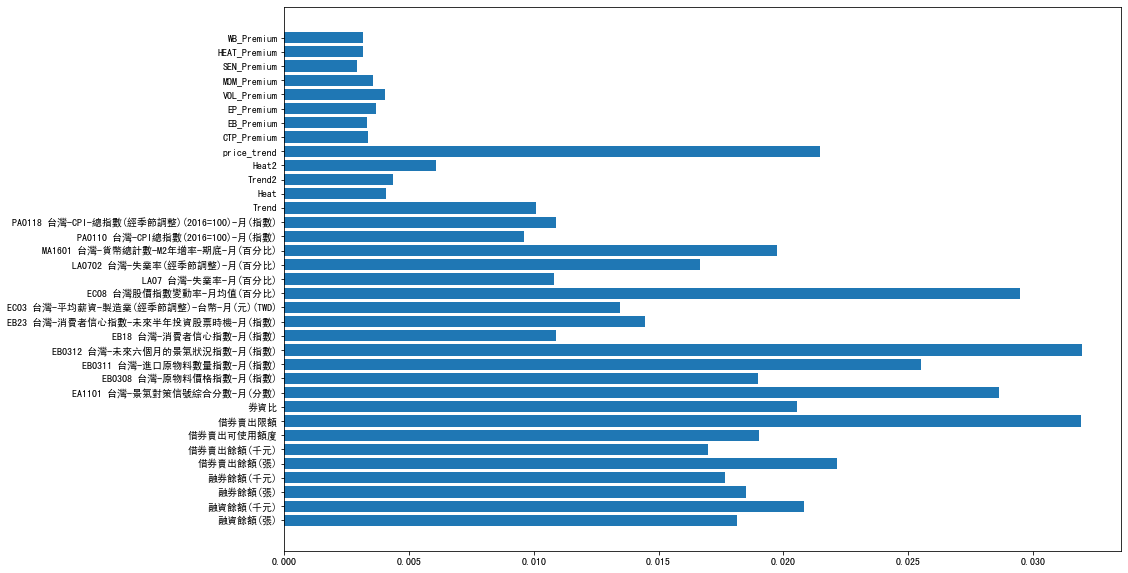

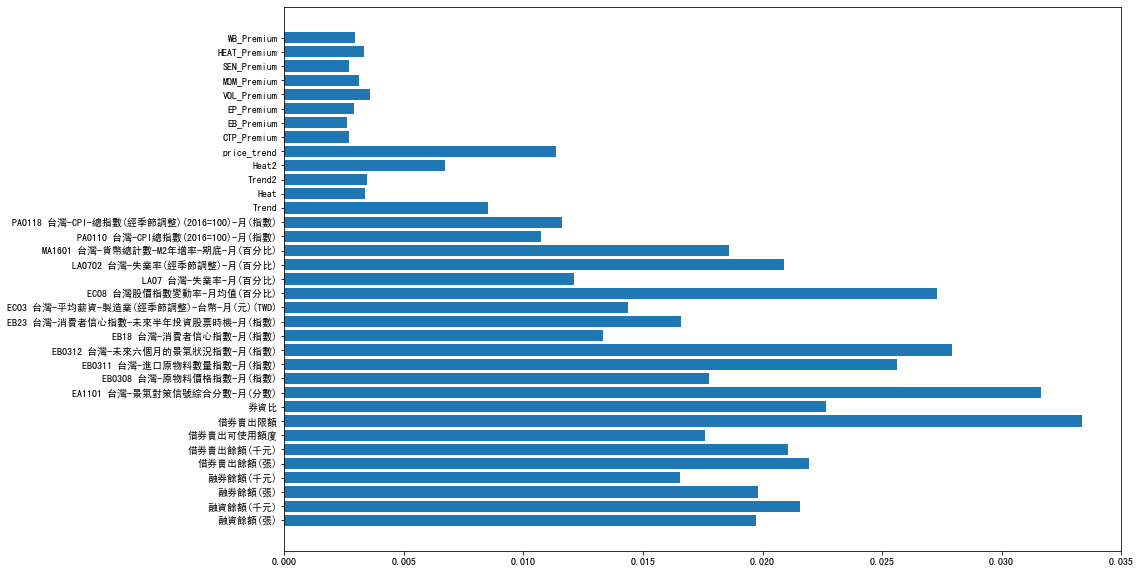

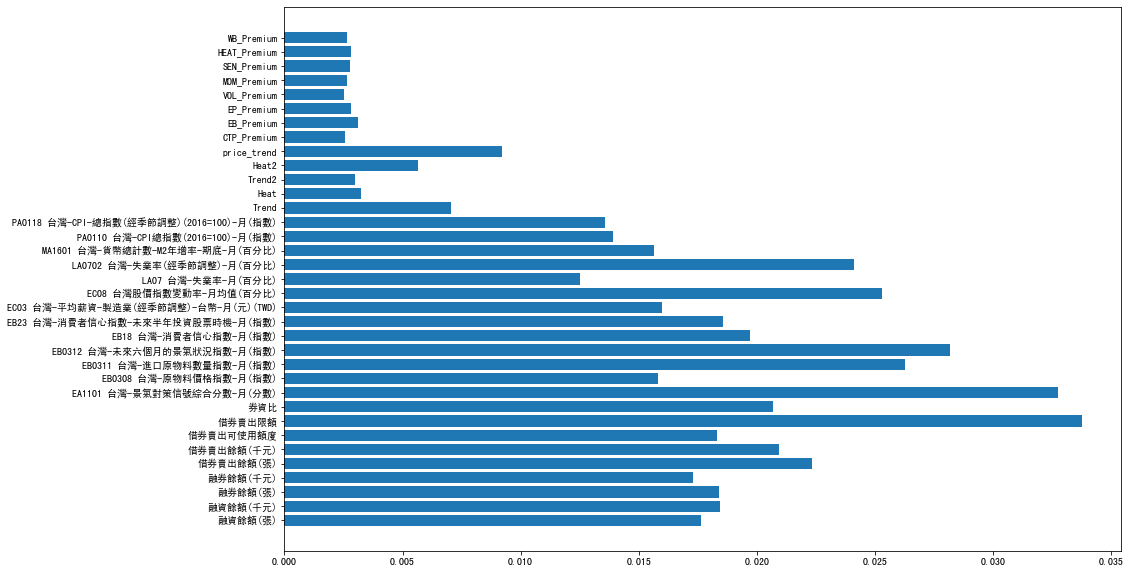

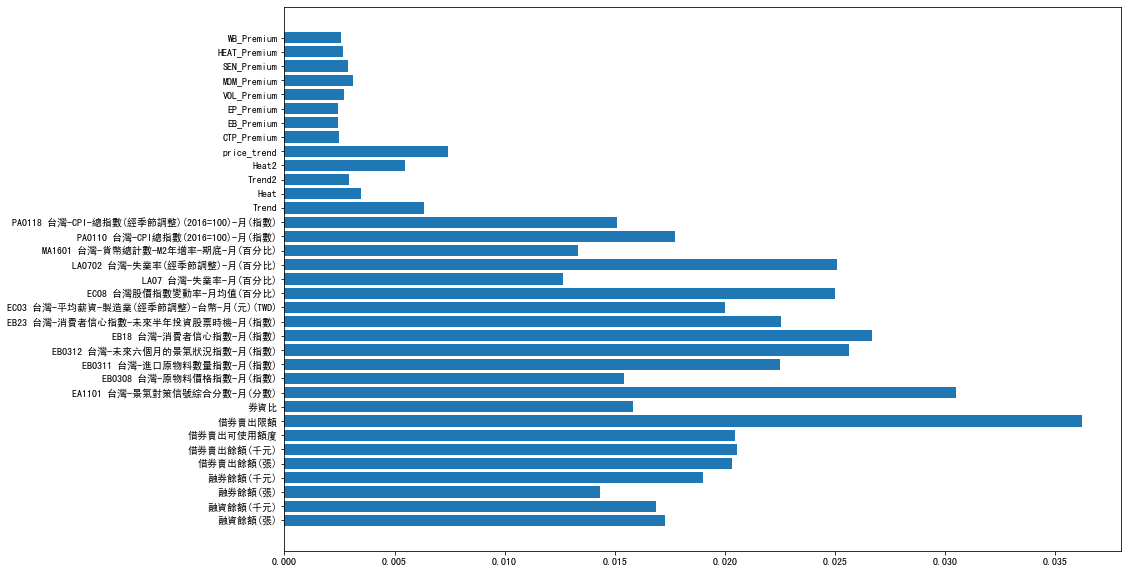

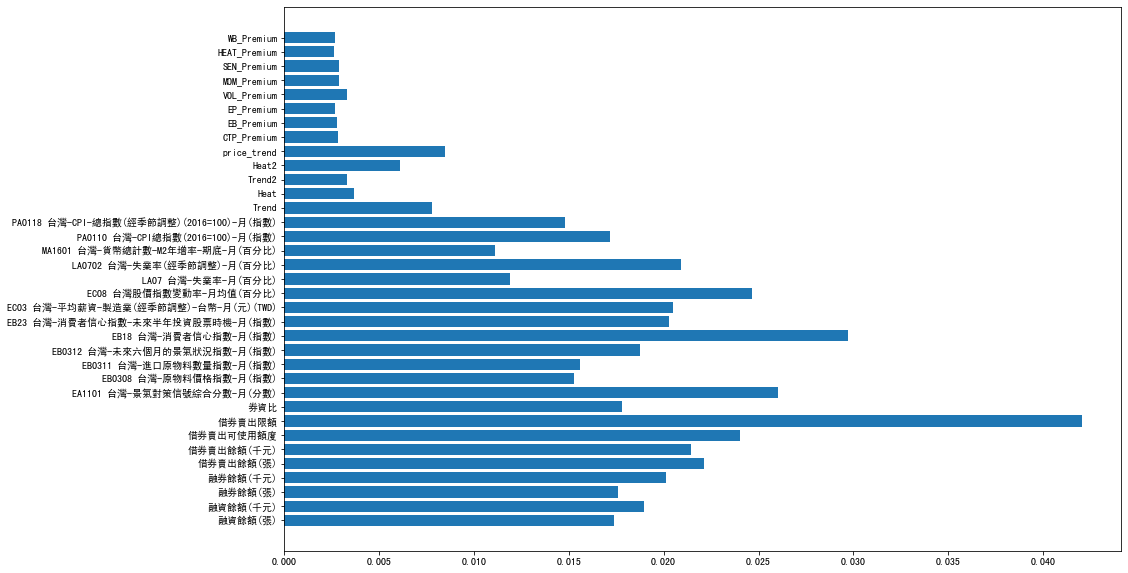

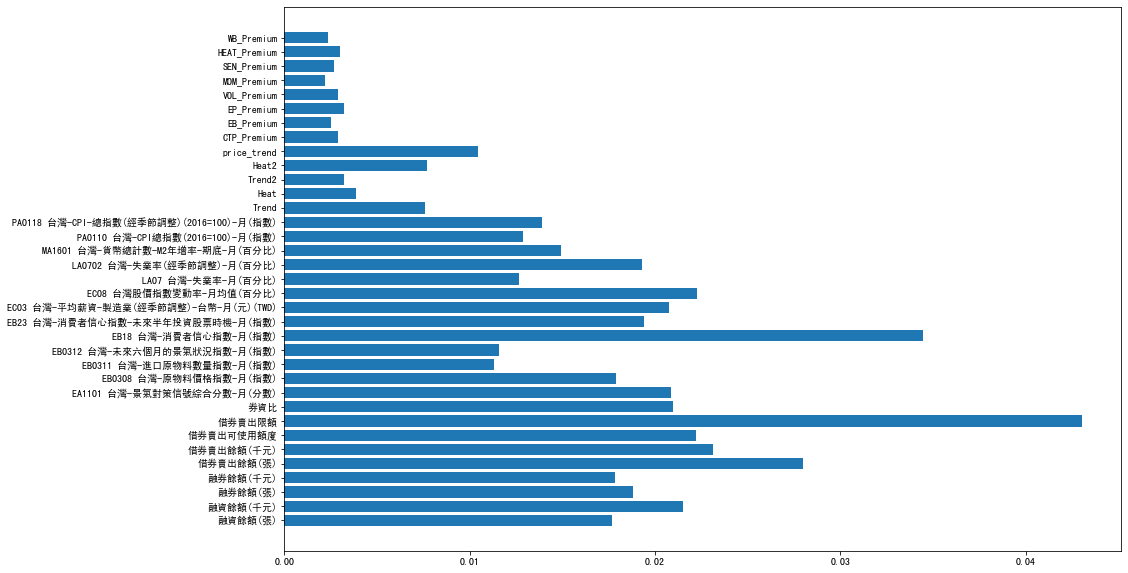

In [27]:
num = len(df_4.columns)
feature_names = df_4.columns[ list(range(1, 10))+list(range(14, num)) ].values

delay = 30
for delay in [1, 5, 10, 15, 20 ,30]:
    X = df_4.iloc[:-delay, list(range(1, 10))+list(range(14, num))].values
    y = df_4.iloc[delay:, 12].values
    clf = RandomForestClassifier(n_estimators=100)
    
    feature_importances = np.array([0.0]*35)
    for epoch in range(50):
        print(epoch, end=' ')
        clf.fit(X, y)
        feature_importances += clf.feature_importances_
    #     y_predict = clf.predict(X)
    #     confusionMatrix = confusion_matrix(y, y_predict)
    #     print(confusionMatrix)
    #     print('Accuracy: ', (confusionMatrix[0,0]+confusionMatrix[1,1])/sum(sum(confusionMatrix)))

    plt.figure(figsize=(15,10))
    plt.barh(feature_names, feature_importances/50)

# 季 - Random Forest - SFM, RFECV(X, too much time)

In [87]:
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

num = len(df_4.columns)

def nor(lis):
    lis = lis.astype(float)
    lis = (np.array(lis) - np.nanmean(lis)) / (np.nanvar(lis))**(1/2)
    return lis

for i in df_4.columns[ list(range(1, 10))+list(range(14, num)) ]:
    try:
        df_4[i] = nor(df_4[i])
    except:
        print(i)
        continue

clf1 = RandomForestClassifier(n_estimators=100)
clf5 = RandomForestClassifier(n_estimators=100)
clf10 = RandomForestClassifier(n_estimators=100)
clf15 = RandomForestClassifier(n_estimators=100)
clf20 = RandomForestClassifier(n_estimators=100)
clf30 = RandomForestClassifier(n_estimators=100)
clf60 = RandomForestClassifier(n_estimators=100)
clf90 = RandomForestClassifier(n_estimators=100)

BBPredict = pd.DataFrame(index=df_4.Date, columns=['PredictLabel'])

for year in range(2014, 2022):
# for year in range(2014, 2015):
    for month in [4, 6, 9, 12]: # 3, 5, 8, 11 -> 4, 6, 9, 12
        split = start = end = 0
#         if month == 4:
#             split = df_4[df_4['年月日'] < str(year)+'/04/01'].shape[0] # 3210
#             start = df_4[df_4['年月日'] < str(year-1)+'/12/01'].shape[0] # 3210
#             end = df_4[df_4['年月日'] < str(year)+'/06/01'].shape[0]
#         elif month == 6:
#             split = df_4[df_4['年月日'] < str(year)+'/06/01'].shape[0] # 3210
#             start = df_4[df_4['年月日'] < str(year)+'/04/01'].shape[0] # 3210
#             end = df_4[df_4['年月日'] < str(year)+'/09/01'].shape[0]
#         elif month == 9:
#             split = df_4[df_4['年月日'] < str(year)+'/09/01'].shape[0] # 3210
#             start = df_4[df_4['年月日'] < str(year)+'/06/01'].shape[0] # 3210
#             end = df_4[df_4['年月日'] < str(year)+'/12/01'].shape[0]
#         elif month == 12:
#             split = df_4[df_4['年月日'] < str(year)+'/12/01'].shape[0] # 3210
#             start = df_4[df_4['年月日'] < str(year)+'/09/01'].shape[0] # 3210
#             end = df_4[df_4['年月日'] < str(year+1)+'/04/01'].shape[0]
        
#         start -= 150 ############## start earlier ##############

        if month == 4:
            split = df_4[df_4['年月日'] < str(year)+'/04/01'].shape[0] # 3210
            start = df_4[df_4['年月日'] < str(year-1)+'/04/01'].shape[0] # 3210
            end = df_4[df_4['年月日'] < str(year)+'/06/01'].shape[0]
        elif month == 6:
            split = df_4[df_4['年月日'] < str(year)+'/06/01'].shape[0] # 3210
            start = df_4[df_4['年月日'] < str(year-1)+'/06/01'].shape[0] # 3210
            end = df_4[df_4['年月日'] < str(year)+'/09/01'].shape[0]
        elif month == 9:
            split = df_4[df_4['年月日'] < str(year)+'/09/01'].shape[0] # 3210
            start = df_4[df_4['年月日'] < str(year-1)+'/09/01'].shape[0] # 3210
            end = df_4[df_4['年月日'] < str(year)+'/12/01'].shape[0]
        elif month == 12:
            split = df_4[df_4['年月日'] < str(year)+'/12/01'].shape[0] # 3210
            start = df_4[df_4['年月日'] < str(year-1)+'/12/01'].shape[0] # 3210
            end = df_4[df_4['年月日'] < str(year+1)+'/04/01'].shape[0]
    
#         for delay in [1, 5, 10, 15, 20, 30, 60 ,90]:
        for delay in [1, 5, 10, 15, 20, 30]:
#         for delay in [1]:

            if delay == 1:
                clf = clf1
            elif delay == 5:
                clf = clf5
            elif delay == 10:
                clf = clf10
            elif delay == 15:
                clf = clf15
            elif delay == 20:
                clf = clf20
            elif delay == 30:
                clf = clf30
            elif delay == 60:
                clf = clf60
            elif delay == 90:
                clf = clf90

            sel = SelectFromModel(clf)
#             sel = RFECV(clf, cv=5)
            
#             start = 0 ############## start from the very beginning ##############

            X_train = df_4.iloc[start:split-delay, list(range(1, 10))+list(range(14, num))].values
            y_train = df_4.iloc[start+delay:split, 12].values
            X_test = df_4.iloc[split-delay:end-delay, list(range(1, 10))+list(range(14, num))].values
            y_test = df_4.iloc[split:end, 12].values

            print('\n', X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    #         print('\n')

            accuracy_list = []

            for epoch in range(10):
                sel.fit(X_train, y_train)
                X_train_new = sel.transform(X_train)
                clf.fit(X_train_new, y_train)
                X_test_new = sel.transform(X_test)
                y_predict = clf.predict(X_test_new)
                
#                 X_train_new = copy.copy(X_train)
#                 clf.fit(X_train_new, y_train)
#                 X_test_new = copy.copy(X_test)
#                 y_predict = clf.predict(X_test_new)


    #             y_predict = clf.predict_proba(X_test_new)
    #             thres = 0.75
    #             y_cut = (y_predict[:,0] > thres) | (y_predict [:,1] > thres) # cut y value and leave the better result
    #             predictions_2 = np.argmax(y_predict[y_cut], axis=-1)
    #             confusionMatrix = confusion_matrix(y_test[y_cut], predictions_2)
                confusionMatrix = confusion_matrix(y_test, y_predict)
#                 print(confusionMatrix)
                try:
                    accuracy = (confusionMatrix[0, 0]+confusionMatrix [1,1])/sum(sum(confusionMatrix))
                except:
#                     print('continue', end=' ')
#                     continue
                    accuracy = 1.0
    #             print(accuracy, end=' ')
                accuracy_list.append(accuracy)
            if len(accuracy_list) > 0:
                print('Year: ', year, 'Month: ', month, 'Delay: ', delay, 'Bull Percentage: ', sum(y_test)/len(y_test), 'Average Accuracy: ', sum(accuracy_list)/len(accuracy_list))
            
            for date_index in range(len(df_4.iloc[split:end, 0])):
                if len(clf.predict_proba(X_test_new)[date_index]) == 2:
                    BBPredict.loc[df_4.iloc[split:end, 0].values[date_index], 'PredictLabel'] = np.append(BBPredict.loc[df_4.iloc[split:end, 0].values[date_index], 'PredictLabel'], str(clf.predict_proba(X_test_new)[date_index][1]))
                else:
                    BBPredict.loc[df_4.iloc[split:end, 0].values[date_index], 'PredictLabel'] = np.append(BBPredict.loc[df_4.iloc[split:end, 0].values[date_index], 'PredictLabel'], str(clf.predict_proba(X_test_new)[date_index][0]))

#             print(y_test, y_predict)
#             print(confusionMatrix)
#             print(clf.feature_importances_)

In [71]:
def NaNmean(x):
    if type(x) != float:
        x = [float(i) for i in x]
        return np.nanmean(x)
    else:
        return float('nan')

def floatlabel(x, delay):
    if type(x) != float:
        delay = -(delay+1)
        x = [float(i) for i in x]
        return x[delay]
    else:
        return float('nan')

BBPredict = BBPredict.fillna(float('nan'))    
BBPredict['PredictLabelMean'] = BBPredict['PredictLabel'].apply(lambda x:NaNmean(x))
BBPredict['PredictLabel1'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=0))
BBPredict['PredictLabel5'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=1))
BBPredict['PredictLabel10'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=2))
BBPredict['PredictLabel15'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=3))
BBPredict['PredictLabel20'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=4))
BBPredict['PredictLabel30'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=5))

df = label.merge(BBPredict, on='Date')
df = df.dropna().reset_index(drop=True)
df

,X,Date,close_adj,volume,algoDefine,bb,PredictLabel,PredictLabelMean,PredictLabel1,PredictLabel5,PredictLabel10,PredictLabel15,PredictLabel20,PredictLabel30
0,1550,2014/04/01,13109.80,4607052,True,1,"[nan, 0.94, 1.0, 0.99, 1.0, 0.99, 0.82]",0.956667,0.82,0.99,1.00,0.99,1.00,0.94
1,1551,2014/04/02,13157.54,5131398,True,1,"[nan, 0.9, 1.0, 0.99, 1.0, 0.99, 0.69]",0.928333,0.69,0.99,1.00,0.99,1.00,0.90
2,1552,2014/04/03,13132.55,4817592,True,1,"[nan, 0.89, 1.0, 0.96, 1.0, 0.99, 0.71]",0.925000,0.71,0.99,1.00,0.96,1.00,0.89
3,1553,2014/04/07,13114.68,4514514,True,1,"[nan, 0.88, 0.96, 0.97, 1.0, 1.0, 0.7]",0.918333,0.70,1.00,1.00,0.97,0.96,0.88
4,1554,2014/04/08,13132.12,4502406,True,1,"[nan, 0.88, 0.95, 0.9, 1.0, 1.0, 0.83]",0.926667,0.83,1.00,1.00,0.90,0.95,0.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,3449,2021/12/24,35628.29,6294056,True,1,"[nan, 1.0, 1.0, 0.96, 0.95, 0.99, 0.95]",0.975000,0.95,0.99,0.95,0.96,1.00,1.00
1900,3450,2021/12/27,35801.46,6063084,True,1,"[nan, 1.0, 1.0, 0.97, 0.95, 0.98, 0.96]",0.976667,0.96,0.98,0.95,0.97,1.00,1.00
1901,3451,2021/12/28,36094.77,6288478,True,1,"[nan, 1.0, 1.0, 0.97, 0.95, 0.99, 0.97]",0.980000,0.97,0.99,0.95,0.97,1.00,1.00
1902,3452,2021/12/29,36196.87,6188965,True,1,"[nan, 1.0, 1.0, 0.97, 0.95, 0.99, 0.96]",0.978333,0.96,0.99,0.95,0.97,1.00,1.00


In [72]:
def intlabel(x, thres):
    if x > thres:
        return 1
    else:
        return 0

for delay in [1, 5, 10, 15, 20, 30]:

    df['PredictLabel' + str(delay) + '_2_int'] = df['PredictLabel' + str(delay)].apply(lambda x: intlabel(x, 0.5))
    confusionMatrix = confusion_matrix(df['bb'], df['PredictLabel' + str(delay) + '_2_int'])
    print(confusionMatrix)
    if confusionMatrix.shape[0] == 2:
        print((confusionMatrix[0,0]+confusionMatrix[1,1])/sum(sum(confusionMatrix)))
    else:
        print((confusionMatrix[1,1]+confusionMatrix[2,2])/sum(sum(confusionMatrix[1:, 1:])))
        
df['PredictLabelMean_2_int'] = df['PredictLabelMean'].apply(lambda x: intlabel(x, 0.5))
confusionMatrix = confusion_matrix(df['bb'], df['PredictLabelMean_2_int'])
print(confusionMatrix)
if confusionMatrix.shape[0] == 2:
    print((confusionMatrix[0,0]+confusionMatrix[1,1])/sum(sum(confusionMatrix)))
else:
    print((confusionMatrix[1,1]+confusionMatrix[2,2])/sum(sum(confusionMatrix[1:, 1:])))
# df['quarterLabel'] = df['PredictLabel30'].apply(lambda x: intlabel(x, 0.3))

[[ 259  290]
 [ 306 1049]]
0.6869747899159664
[[ 286  263]
 [ 316 1039]]
0.6959033613445378
[[ 242  307]
 [ 204 1151]]
0.7316176470588235
[[ 294  255]
 [ 258 1097]]
0.7305672268907563
[[ 298  251]
 [ 233 1122]]
0.7457983193277311
[[ 302  247]
 [ 293 1062]]
0.7163865546218487
[[ 308  241]
 [ 176 1179]]
0.7809873949579832


<BarContainer object of 17 artists>

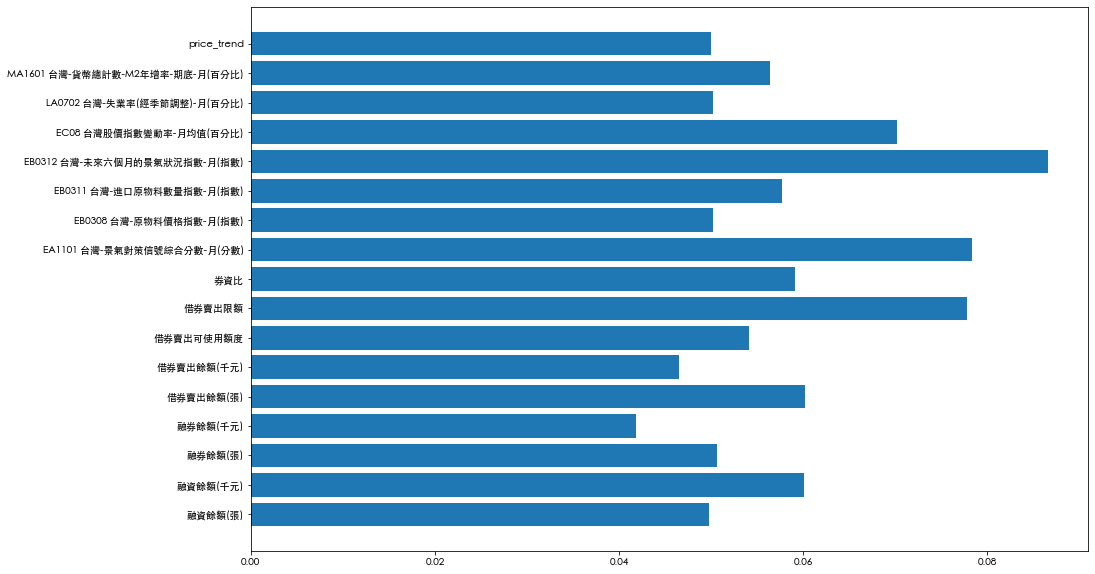

In [85]:
num = len(df_4.columns)
feature_names = df_4.columns[ list(range(1, 10))+list(range(14, num)) ].values
sel = SelectFromModel(clf)

delay = 1
X = df_4.iloc[:-delay, list(range(1, 10))+list(range(14, num))].values
y = df_4.iloc[delay:, 12].values
X_new = sel.fit_transform(X, y)
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_new, y)
plt.figure(figsize=(15,10))
plt.barh(sel.get_feature_names_out(feature_names), clf.feature_importances_)

# 季 - Logistic Regression... - All


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix

num = len(df_4.columns)

def nor(lis):
    lis = lis.astype(float)
    lis = (np.array(lis) - np.nanmean(lis)) / (np.nanvar(lis))**(1/2)
    return lis

for i in df_4.columns[ list(range(1, 10))+list(range(14, num)) ]:
    try:
        df_4[i] = nor(df_4[i])
    except:
        print(i)
        continue

otherAI = SVC(probability=True)
clf1 = clf5 = clf10 = clf15 = clf20 = clf30 = clf60 = clf90 = otherAI


BBPredict = pd.DataFrame(index=df_4.Date, columns=['PredictLabel'])

for year in range(2014, 2022):
# for year in range(2014, 2015):
    for month in [4, 6, 9, 12]: # 3, 5, 8, 11 -> 4, 6, 9, 12
        split = start = end = 0

        if month == 4:
            split = df_4[df_4['年月日'] < str(year)+'/04/01'].shape[0] # 3210
            start = df_4[df_4['年月日'] < str(year-1)+'/04/01'].shape[0] # 3210
            end = df_4[df_4['年月日'] < str(year)+'/06/01'].shape[0]
        elif month == 6:
            split = df_4[df_4['年月日'] < str(year)+'/06/01'].shape[0] # 3210
            start = df_4[df_4['年月日'] < str(year-1)+'/06/01'].shape[0] # 3210
            end = df_4[df_4['年月日'] < str(year)+'/09/01'].shape[0]
        elif month == 9:
            split = df_4[df_4['年月日'] < str(year)+'/09/01'].shape[0] # 3210
            start = df_4[df_4['年月日'] < str(year-1)+'/09/01'].shape[0] # 3210
            end = df_4[df_4['年月日'] < str(year)+'/12/01'].shape[0]
        elif month == 12:
            split = df_4[df_4['年月日'] < str(year)+'/12/01'].shape[0] # 3210
            start = df_4[df_4['年月日'] < str(year-1)+'/12/01'].shape[0] # 3210
            end = df_4[df_4['年月日'] < str(year+1)+'/04/01'].shape[0]
    
        for delay in [1, 5, 10, 15, 20, 30]:

            if delay == 1:
                clf = clf1
            elif delay == 5:
                clf = clf5
            elif delay == 10:
                clf = clf10
            elif delay == 15:
                clf = clf15
            elif delay == 20:
                clf = clf20
            elif delay == 30:
                clf = clf30
            elif delay == 60:
                clf = clf60
            elif delay == 90:
                clf = clf90
            
#             start = 0 ############## start from the very beginning ##############

            X_train = df_4.iloc[start:split-delay, list(range(1, 10))+list(range(14, num))].values
            y_train = df_4.iloc[start+delay:split, 12].values
            X_test = df_4.iloc[split-delay:end-delay, list(range(1, 10))+list(range(14, num))].values
            y_test = df_4.iloc[split:end, 12].values

            print('\n', X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    #         print('\n')

            accuracy_list = []

            for epoch in range(10):
#                 sel.fit(X_train, y_train)
#                 X_train_new = sel.transform(X_train)
#                 clf.fit(X_train_new, y_train)
#                 X_test_new = sel.transform(X_test)
#                 y_predict = clf.predict(X_test_new)
                
                X_train_new = copy.copy(X_train)
                clf.fit(X_train_new, y_train)
                X_test_new = copy.copy(X_test)
                y_predict = clf.predict(X_test_new)
    
                confusionMatrix = confusion_matrix(y_test, y_predict)
#                 print(confusionMatrix)
                try:
                    accuracy = (confusionMatrix[0, 0]+confusionMatrix [1,1])/sum(sum(confusionMatrix))
                except:
#                     print('continue', end=' ')
#                     continue
                    accuracy = 1.0
    #             print(accuracy, end=' ')
                accuracy_list.append(accuracy)
            if len(accuracy_list) > 0:
                print('Year: ', year, 'Month: ', month, 'Delay: ', delay, 'Bull Percentage: ', sum(y_test)/len(y_test), 'Average Accuracy: ', sum(accuracy_list)/len(accuracy_list))
            
            for date_index in range(len(df_4.iloc[split:end, 0])):
                if len(clf.predict_proba(X_test_new)[date_index]) == 2:
                    BBPredict.loc[df_4.iloc[split:end, 0].values[date_index], 'PredictLabel'] = np.append(BBPredict.loc[df_4.iloc[split:end, 0].values[date_index], 'PredictLabel'], str(clf.predict_proba(X_test_new)[date_index][1]))
                else:
                    BBPredict.loc[df_4.iloc[split:end, 0].values[date_index], 'PredictLabel'] = np.append(BBPredict.loc[df_4.iloc[split:end, 0].values[date_index], 'PredictLabel'], str(clf.predict_proba(X_test_new)[date_index][0]))


 (245, 35) (245,) (42, 35) (42,)
Year:  2014 Month:  4 Delay:  1 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.9285714285714286

 (241, 35) (241,) (42, 35) (42,)
Year:  2014 Month:  4 Delay:  5 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.9285714285714286

 (236, 35) (236,) (42, 35) (42,)
Year:  2014 Month:  4 Delay:  10 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.9285714285714286

 (231, 35) (231,) (42, 35) (42,)
Year:  2014 Month:  4 Delay:  15 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.8809523809523812

 (226, 35) (226,) (42, 35) (42,)
Year:  2014 Month:  4 Delay:  20 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.5238095238095238

 (216, 35) (216,) (42, 35) (42,)
Year:  2014 Month:  4 Delay:  30 Bull Percentage:  0.9285714285714286 Average Accuracy:  0.7857142857142857

 (245, 35) (245,) (63, 35) (63,)
Year:  2014 Month:  6 Delay:  1 Bull Percentage:  1.0 Average Accuracy:  1.0

 (241, 35) (241,) (63, 35) (63,)
Year:

KeyboardInterrupt: 

In [99]:
BBPredict = BBPredict.fillna(float('nan'))    
BBPredict['PredictLabelMean'] = BBPredict['PredictLabel'].apply(lambda x:NaNmean(x))
BBPredict['PredictLabel1'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=0))
BBPredict['PredictLabel5'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=1))
BBPredict['PredictLabel10'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=2))
BBPredict['PredictLabel15'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=3))
BBPredict['PredictLabel20'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=4))
BBPredict['PredictLabel30'] = BBPredict['PredictLabel'].apply(lambda x:floatlabel(x, delay=5))

df = label.merge(BBPredict, on='Date')
df = df.dropna().reset_index(drop=True)
    
for delay in [1, 5, 10, 15, 20, 30]:

    df['PredictLabel' + str(delay) + '_2_int'] = df['PredictLabel' + str(delay)].apply(lambda x: intlabel(x, 0.5))
    confusionMatrix = confusion_matrix(df['bb'], df['PredictLabel' + str(delay) + '_2_int'])
    print(confusionMatrix)
    if confusionMatrix.shape[0] == 2:
        print((confusionMatrix[0,0]+confusionMatrix[1,1])/sum(sum(confusionMatrix)))
    else:
        print((confusionMatrix[1,1]+confusionMatrix[2,2])/sum(sum(confusionMatrix[1:, 1:])))
        
df['PredictLabelMean_2_int'] = df['PredictLabelMean'].apply(lambda x: intlabel(x, 0.5))
confusionMatrix = confusion_matrix(df['bb'], df['PredictLabelMean_2_int'])
print(confusionMatrix)
if confusionMatrix.shape[0] == 2:
    print((confusionMatrix[0,0]+confusionMatrix[1,1])/sum(sum(confusionMatrix)))
else:
    print((confusionMatrix[1,1]+confusionMatrix[2,2])/sum(sum(confusionMatrix[1:, 1:])))

[[ 219  330]
 [ 222 1133]]
0.7100840336134454
[[ 200  349]
 [ 262 1093]]
0.6790966386554622
[[ 221  328]
 [ 267 1088]]
0.6875
[[ 215  334]
 [ 233 1122]]
0.7022058823529411
[[ 219  330]
 [ 276 1079]]
0.6817226890756303
[[ 246  303]
 [ 273 1082]]
0.6974789915966386
[[ 234  315]
 [ 208 1147]]
0.7253151260504201


# 下面沒用到

In [71]:
clf1.coef_

array([[ 0.10893416, -0.23263161, -0.93999691, -2.1862725 ,  0.84855967,
         0.05814662, -1.62441817,  0.0953209 , -1.20261055,  0.77345156,
         1.07071106, -0.34460249,  0.44606841,  0.1018785 ,  1.68403403,
        -0.41873339,  0.32301407,  0.23869891,  1.85887337,  1.3414616 ,
        -0.71180239, -0.00803005,  1.0888479 ,  0.46447084, -0.10673453,
         0.70881594,  0.76838129, -0.14529863, -0.21176106,  0.2154443 ,
        -0.05638875, -0.10353205, -0.21659032,  0.48572284, -0.04485376]])

In [98]:
stay_factor = []

from sklearn.feature_selection import f_regression
for i in range(len(f_regression(X_train, y_train)[1])):
    factor_name = df_4.iloc[start:split-delay, list(range(1, 10))+list(range(14, num))].columns[i]
    factor_pvalue = f_regression(X_train, y_train)[1][i]
    print(factor_name, factor_pvalue)
    if factor_pvalue <= 0.1:
        stay_factor.append(factor_name)
        
print(stay_factor)
# from sklearn.feature_selection import chi2
# print(chi2(X_train, y_train))

融資餘額(張) 0.0015917587832439083
融資餘額(千元) 0.019601422308624668
融券餘額(張) 0.021096749578755205
融券餘額(千元) 0.012224666794139057
借券賣出餘額(張) 1.4938020159962964e-08
借券賣出餘額(千元) 0.00047658504531682664
借券賣出可使用額度 0.871900912900603
借券賣出限額 0.23069601979440002
券資比 6.623721822498716e-05
EA1101 台灣-景氣對策信號綜合分數-月(分數) 0.01720371604747053
EB0308 台灣-原物料價格指數-月(指數) 0.5912008718782857
EB0311 台灣-進口原物料數量指數-月(指數) 0.14745526933147518
EB0312 台灣-未來六個月的景氣狀況指數-月(指數) 0.03709792368749935
EB18 台灣-消費者信心指數-月(指數) 4.65711624359635e-11
EB23 台灣-消費者信心指數-未來半年投資股票時機-月(指數) 3.055943912202899e-09
EC03 台灣-平均薪資-製造業(經季節調整)-台幣-月(元)(TWD) 0.26098922993801893
EC08 台灣股價指數變動率-月均值(百分比) 1.8206784910950744e-05
LA07 台灣-失業率-月(百分比) 4.5304790456209365e-08
LA0702 台灣-失業率(經季節調整)-月(百分比) 6.193113089294338e-06
MA1601 台灣-貨幣總計數-M2年增率-期底-月(百分比) 0.05328313718251052
PA0110 台灣-CPI總指數(2016=100)-月(指數) 0.0027581113003145763
PA0118 台灣-CPI-總指數(經季節調整)(2016=100)-月(指數) 5.201673336923729e-07
Trend 0.0034974084108564817
Heat 0.15279477568737285
Trend2 0.13950527859328682
Heat

# 看看使用sklearn.feature_selection 裡的 f_regression後的結果

In [109]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import statsmodels.api as sm

num = len(df_4.columns)

def nor(lis):
    lis = lis.astype(float)
    lis = (np.array(lis) - np.nanmean(lis)) / (np.nanvar(lis))**(1/2)
    return lis

for i in df_4.columns[ list(range(1, 10))+list(range(14, num)) ]:
    try:
        df_4[i] = nor(df_4[i])
    except:
        print(i)
        continue

clf1 = LogisticRegression()
clf5 = LogisticRegression()
clf10 = LogisticRegression()
clf15 = LogisticRegression()
clf20 = LogisticRegression()

for year in range(2014, 2022):
    
    split = df_4[df_4['年月日'] < str(year)+'/01/01'].shape[0] # 3210
    start = df_4[df_4['年月日'] < str(year-1)+'/01/01'].shape[0] # 3210
    end = df_4[df_4['年月日'] < str(year+1)+'/01/01'].shape[0] 
    
    for delay in [1, 5, 10, 15, 20]:
        
        if delay == 1:
            clf = clf1
        elif delay == 5:
            clf = clf5
        elif delay == 10:
            clf = clf10
        elif delay == 15:
            clf = clf15
        elif delay == 20:
            clf = clf20
            

        X_train = df_4.loc[start:split-delay-1, stay_factor].values # 多減1!!!
        y_train = df_4.iloc[start+delay:split, 12].values
        X_test = df_4.loc[split-delay:end-delay-1, stay_factor].values # 多減1!!!
        y_test = df_4.iloc[split:end, 12].values

        print('\n', X_train.shape, y_train.shape, X_test.shape, y_test.shape)
#         print('\n')

        accuracy_list = []

        for epoch in range(10):
            clf.fit(X_train, y_train)
            y_predict = clf.predict(X_test)
            confusionMatrix = confusion_matrix(y_test, y_predict)
#             print(confusionMatrix)
            accuracy = (confusionMatrix[0, 0]+confusionMatrix [1,1])/sum(sum(confusionMatrix))
    #         print(accuracy)
            accuracy_list.append(accuracy)
        print('Year: ', year, 'Delay: ', delay, 'Average Accuracy: ', sum(accuracy_list)/len(accuracy_list))


 (189, 22) (189,) (248, 22) (248,)
Year:  2014 Delay:  1 Average Accuracy:  0.8540322580645162

 (185, 22) (185,) (248, 22) (248,)
Year:  2014 Delay:  5 Average Accuracy:  0.8588709677419357

 (180, 22) (180,) (248, 22) (248,)
Year:  2014 Delay:  10 Average Accuracy:  0.8326612903225807

 (175, 22) (175,) (248, 22) (248,)
Year:  2014 Delay:  15 Average Accuracy:  0.5479838709677419

 (170, 22) (170,) (248, 22) (248,)
Year:  2014 Delay:  20 Average Accuracy:  0.6189516129032258

 (247, 22) (247,) (244, 22) (244,)
Year:  2015 Delay:  1 Average Accuracy:  0.3155737704918033

 (243, 22) (243,) (244, 22) (244,)
Year:  2015 Delay:  5 Average Accuracy:  0.3155737704918033

 (238, 22) (238,) (244, 22) (244,)
Year:  2015 Delay:  10 Average Accuracy:  0.3155737704918033

 (233, 22) (233,) (244, 22) (244,)
Year:  2015 Delay:  15 Average Accuracy:  0.3155737704918033

 (228, 22) (228,) (244, 22) (244,)
Year:  2015 Delay:  20 Average Accuracy:  0.3155737704918033

 (243, 22) (243,) (244, 22) (244,

In [167]:
BBPredict.to_csv('BBPredict.csv')